In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn import set_config
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.data import load_data, convert_to_bool, convert_to_ordinal
from src.feature_selection import FeatureImportance

pd.set_option('display.precision',4)
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Predicting the price of used cars
In the data file {download}`ToyotaCorrolla <../data/ToyotaCorolla.csv>` we have data on used Toyotas from late 2004 in the Netherlands.  The goal is to predict the price based on it's specifications.

Note there has been some significant EDA done ahead of time to reduce the number of columns and find interesting data.
- Cylinders: dropped because all the values are 4

In [3]:
#
# Let's start by checking out the data
cars_df = load_data('ToyotaCorolla',index_col='Id')
cars_df = cars_df.drop(columns=['Cylinders','Model'])
cars_df.shape

/workspaces/AdvPythonML/data/ToyotaCorolla.csv


(1436, 36)

_NOTE:_ Maybe it's worth noting (many notebooks leave these steps out because they are cumbersome and more complex to explain than to just do).  In a different notebook, I took a good look at the data to determine how to ensure that the data types were correct for each column.  You could do this in Excel (if your data is small enough) or you might use another tool where you can get a quick sample and try to understand the data.  For me, I took a look at the the types of data `cars_df.dtypes` then since I saw that many of the columns had just a 1 or a 0, I figured these were `boolean`.  Then looking at the names of the columns, like `Mfg_Year` and `Mfg_Month`, even though they are numbers, I felt it would be best to convert them what they are _ordinal_ values.  The other reason that this doesn't get much description is because the process is usually a bit non-linear and repeatitive.  For instance, once I determined the booleans, I converted them and then started looking for categoricals.  This would have taken 4 notebook cells (1. find bools, 2. convert columns to bool, 3. find non-bool number columns, 4. convert to ordinal).  As a reader you are really only interested in seeing the conversion of columns in a single cell instead of all the work behind it.

Another example of the non-linear workflow, I discovered `Cylinders` as a unary value (all cars here have 4 cylinders).  If this column was dropped later in the notebook, then an update to the categorical columns as well.  Instead, I'll just let you know that I found this in a later step.  To be more clear, it was dropped immediately at the start before creating the categorical columns.  Additionally, I found later in the model that there are 300+ different car models in a dataset (within just 1400 rows), so this isn't going to be helpful later on either.

In [4]:
cars_df.dtypes

Price                 int64
Age_08_04             int64
Mfg_Month             int64
Mfg_Year              int64
KM                    int64
Fuel_Type            object
HP                    int64
Met_Color             int64
Color                object
Automatic             int64
CC                    int64
Doors                 int64
Gears                 int64
Quarterly_Tax         int64
Weight                int64
Mfr_Guarantee         int64
BOVAG_Guarantee       int64
Guarantee_Period      int64
ABS                   int64
Airbag_1              int64
Airbag_2              int64
Airco                 int64
Automatic_airco       int64
Boardcomputer         int64
CD_Player             int64
Central_Lock          int64
Powered_Windows       int64
Power_Steering        int64
Radio                 int64
Mistlamps             int64
Sport_Model           int64
Backseat_Divider      int64
Metallic_Rim          int64
Radio_cassette        int64
Parking_Assistant     int64
Tow_Bar             

In [5]:
cars_df = convert_to_bool(cars_df,['Met_Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS',
       'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer',
       'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering',
       'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar'])

ord_columns = ['Model','Mfg_Month', 'Mfg_Year','Doors', 'Gears','Fuel_Type',"Color"]

cars_df = convert_to_ordinal(cars_df,ord_columns)

# Take out the target column before determining the number columns
num_columns = cars_df.drop(columns='Price').select_dtypes(include='number').columns
bool_columns = cars_df.select_dtypes(include='bool').columns
cat_columns = cars_df.select_dtypes(include=['object','category']).columns

print(num_columns)
print(bool_columns)
print(cat_columns)

def remove_column(df, column_collection):
       '''
       Drop a column from the dataframe, as well as from the list associated with the column
       '''
       pass

Index(['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC',
       'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object')
Index(['Met_Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS',
       'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer',
       'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering',
       'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar'],
      dtype='object')
Index(['Mfg_Month', 'Mfg_Year', 'Fuel_Type', 'Color', 'Doors', 'Gears'], dtype='object')


## More EDA
Next, I'm going to do a few more steps to see if I can determine anything interesting about the data.  I'll start with a cumulative density plot of the price.  This helps me to see what the range of prices is and I've also plotted to the IQR's, this can be helpful to see how spread out the prices are.

<AxesSubplot:xlabel='Price', ylabel='Density'>

Text(3250.0, 0.51, 'Median: 9900.0')

Text(3250.0, 0.76, 'IQ3: 11950.0')

Text(3250.0, 0.26, 'IQ1: 8450.0')

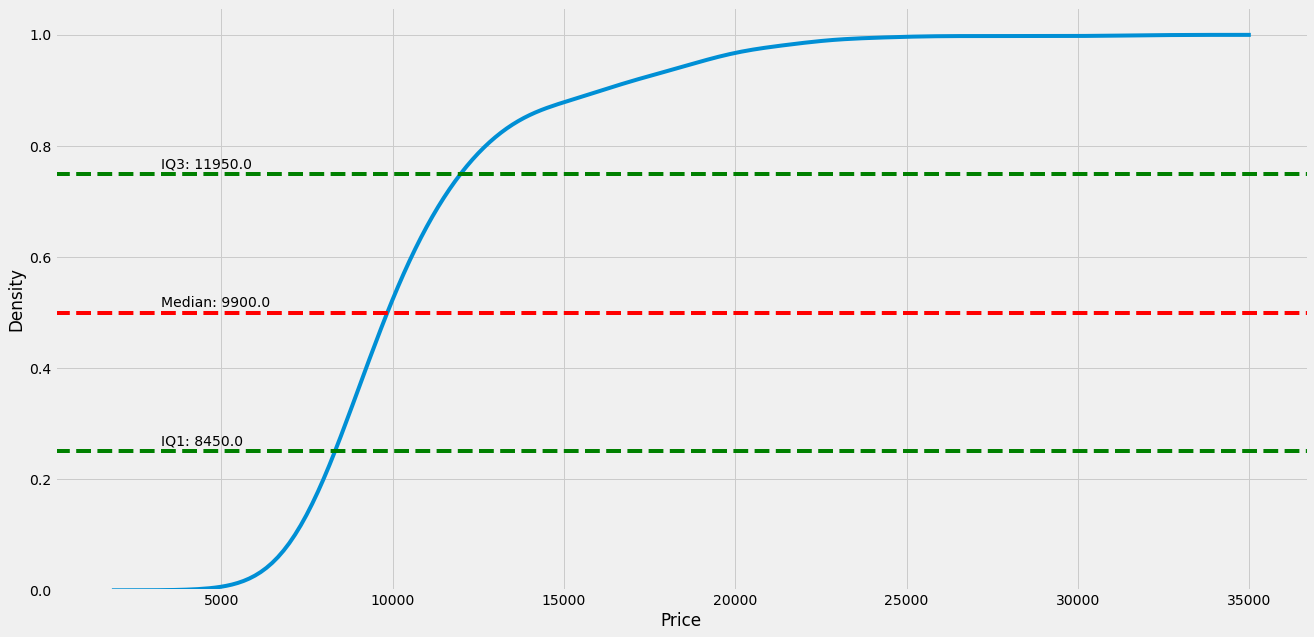

count     1436.0000
mean     10730.8245
std       3626.9646
min       4350.0000
25%       8450.0000
50%       9900.0000
75%      11950.0000
max      32500.0000
Name: Price, dtype: float64

In [6]:
iq1,iq2,iq3 = cars_df.Price.describe()[4:7]
sns.kdeplot(cars_df.Price, cumulative=True);
y=np.full(len(cars_df.Price.cumsum()),0.5)
plt.axhline(y=0.5,color='red',linestyle='--');
plt.axhline(y=0.75,color='green',linestyle='--');
plt.axhline(y=0.25,color='green',linestyle='--');
plt.text(x=0.1*max(cars_df.Price),y=0.51,s=f'Median: {iq2}');
plt.text(x=0.1*max(cars_df.Price),y=0.76,s=f'IQ3: {iq3}');
plt.text(x=0.1*max(cars_df.Price),y=0.26,s=f'IQ1: {iq1}');
plt.show();

cars_df.Price.describe()

In [8]:
# Next, I want to see if  there are cases where there are too many of one class (bool or categorical)
bool_df = cars_df[bool_columns].apply(pd.value_counts).T
bool_df.columns = ['F','T']
bool_df['% True'] = bool_df['T']/bool_df.sum(axis=1)
bool_df.sort_values(by='% True')
cars_df[cat_columns].nunique()

,F,T,% True
Parking_Assistant,1432,4,0.0028
Automatic,1356,80,0.0557
Automatic_airco,1355,81,0.0564
Radio_cassette,1227,209,0.1455
Radio,1226,210,0.1462
Metallic_Rim,1142,294,0.2047
CD_Player,1122,314,0.2187
Mistlamps,1067,369,0.257
Tow_Bar,1037,399,0.2779
Boardcomputer,1013,423,0.2946


Mfg_Month    12
Mfg_Year      7
Fuel_Type     3
Color        10
Doors         4
Gears         4
dtype: int64

Looking at the values above, it seems like `Parking_Assist` is pretty much useless in terms of determining the price since there are only 4 cars with this feature - I'll remove it from the categoricals.

<AxesSubplot:xlabel='Mfg_Year', ylabel='Price'>

<AxesSubplot:xlabel='Fuel_Type', ylabel='Price'>

<AxesSubplot:xlabel='Color', ylabel='Price'>

<AxesSubplot:xlabel='Doors', ylabel='Price'>

<AxesSubplot:xlabel='Gears', ylabel='Price'>

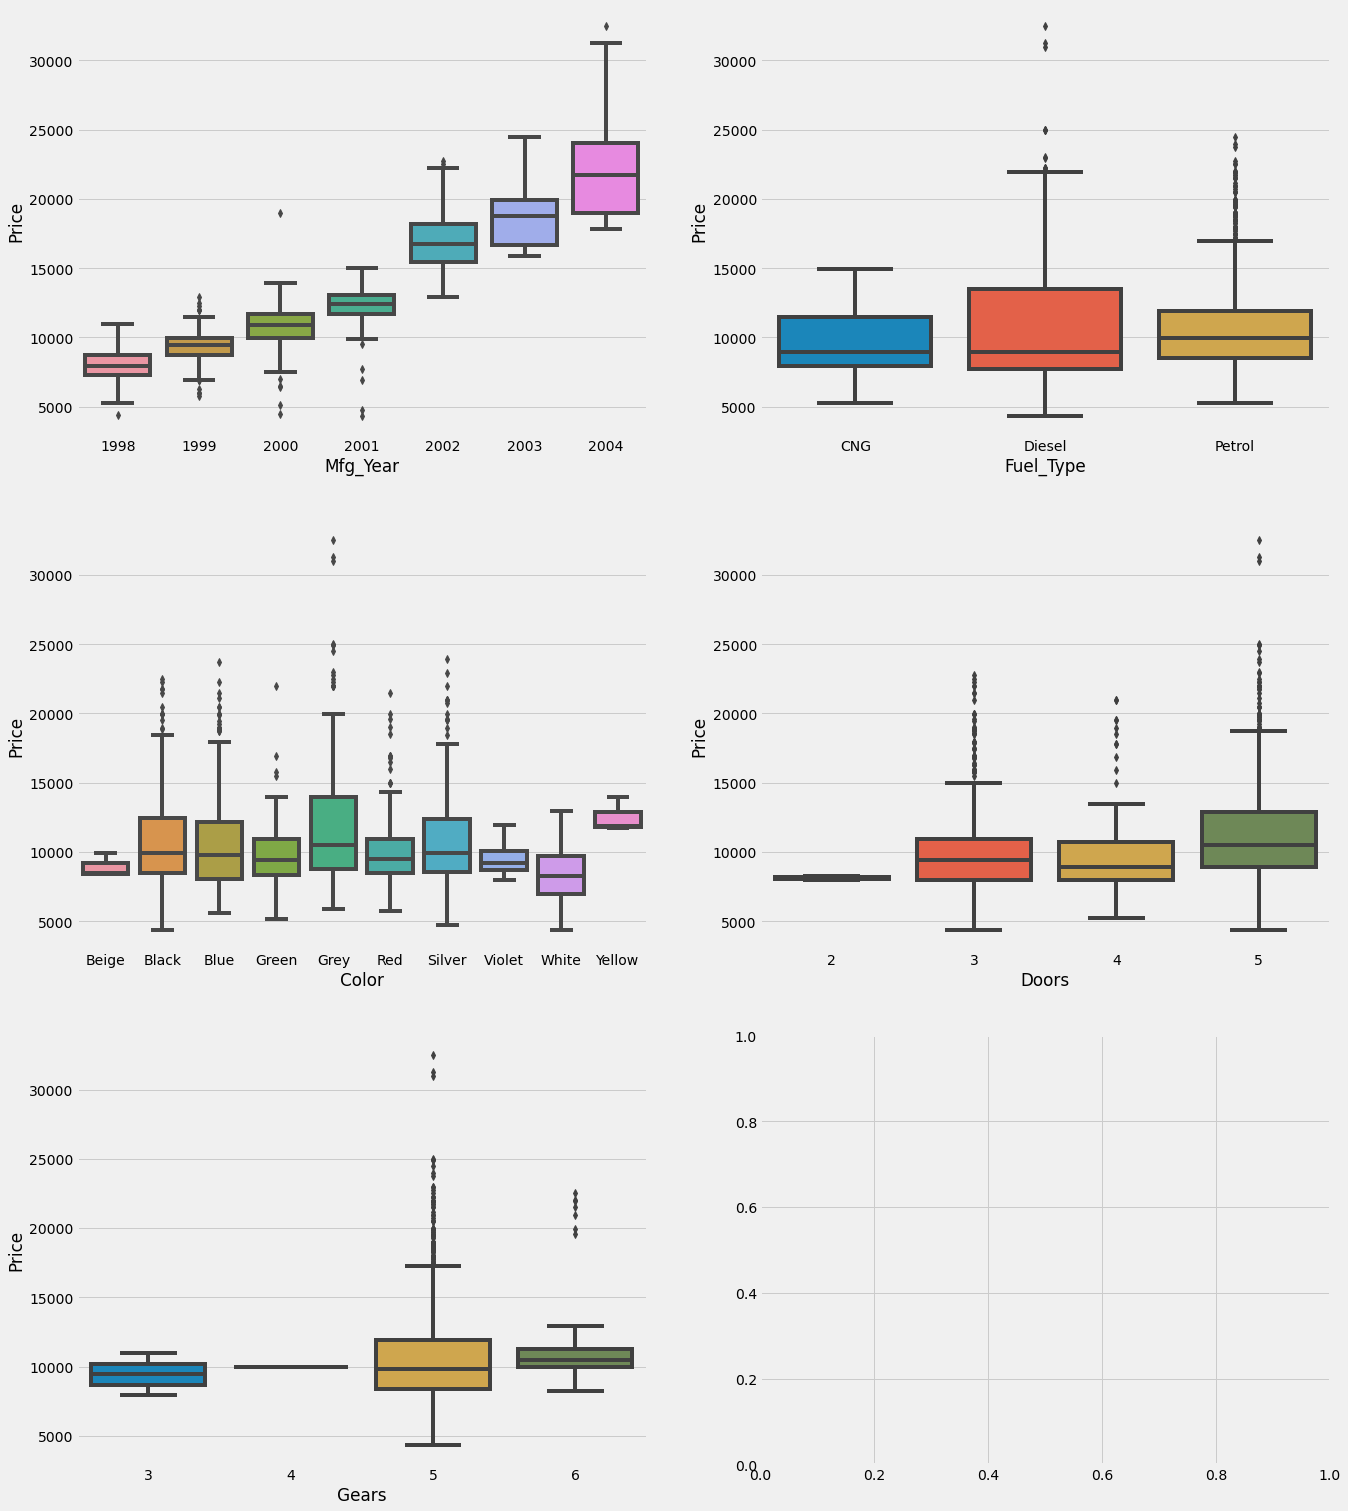

In [9]:
# Now let's see how these categoricals relate to price
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(20,25));
for ax, c in zip(axs.flat,cat_columns[1:]):
    sns.boxplot(data=cars_df, x=c,y='Price',ax=ax);

In [8]:
# We see above that it looks like these values may have some interest (certainly the newer the car the more valuable)
# There seems to be a small number of 2-doors let's see
cars_df['Doors'].value_counts()

5    674
3    622
4    138
2      2
Name: Doors, dtype: int64

In [9]:
# With only 2 samples of 2-door cars, we can safely drop these
cars_df = cars_df.query('Doors>2')

In [10]:
# Next I noticed that the price seems to differ for each color pretty significantly
colors_df = cars_df.groupby('Color')['Price'].mean().sort_values(ascending=False)
colors_df.columns = ['Color','MeanPrice']
colors_df

Color
Yellow    12531.6667
Grey      11927.3422
Black     11085.1058
Silver    11070.6803
Blue      10836.4382
Red        9962.6978
Green      9836.1091
Violet     9575.0000
Beige      8933.3333
White      8207.9032
Name: Price, dtype: float64

## Feature importance
Many of the notebooks you see or some of the examples, skip the step where show how they determined that they only want to use 6-8 of the features that are provided.  I'm going to start by looking at which features are best using a DT regressor, a LinearModel with ForwardSelection and Backward elimination, once we've done this - we can start again by dropping out the features that don't seem to have any value

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')

X = cars_df.drop(columns='Price')
y= cars_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2)
cat_cols = ['Mfg_Month','Fuel_Type','Color']
ord_cols = ['Mfg_Year','Doors', 'Gears']
bool_cols = X_train.select_dtypes(include='bool').columns
num_cols = X_train.select_dtypes(include=np.number).columns

# We're going to setup our column transformer as pre-processing step for the follow-on steps.
pre_processing = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(), cat_cols),
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=99), ord_cols),
    ('num_encoder', StandardScaler(),num_cols)])


In [12]:
pipe = Pipeline([("pp",pre_processing), ("dtr",DecisionTreeRegressor(random_state=123))])

pipe.fit(X_train,y_train)
fi= FeatureImportance(pipe)
fn = fi.get_feature_names()
top_10_tree = fi.get_feature_importance().sort_values(ascending=False)[:10]
top_10_tree.name='top_10_tree'
top_10_tree

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('cat_encoder',
                                                  OneHotEncoder(),
                                                  ['Mfg_Month', 'Fuel_Type',
                                                   'Color']),
                                                 ('ord_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99),
                                                  ['Mfg_Year', 'Doors',
                                                   'Gears']),
                                                 ('num_encoder',
                                                  StandardScaler(),
                                                  Index(['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC',
       'Quarterly_Tax', 'Weight', 'M...AG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object'))])),
                ('dtr', DecisionTreeRegressor(random_state=123))])

Age_08_04          0.8366
KM                 0.0403
HP                 0.0343
Weight             0.0145
Automatic_airco    0.0094
Mfg_Month_1        0.0053
Powered_Windows    0.0043
Quarterly_Tax      0.0038
Mistlamps          0.0038
CC                 0.0030
Name: top_10_tree, dtype: float64

Seems like the `Age`, `KM`, `HP` and `Weight` seem to be the most important variables.  Let's take a look using a different method and see which features float to to the top.  Here we'll try a forest of trees, this ought to give us an even better idea of which parameters are of the most value.

In [13]:
# And now one last try using GridSearch to find the best transformer
param_grid = {'regressor__max_depth': [3,4,5]}

pipe = Pipeline([("pp",pre_processing), ("regressor",DecisionTreeRegressor(random_state=123))])
reg = GridSearchCV(pipe,param_grid=param_grid)
reg.fit(X_train, y_train)
best= reg.best_estimator_

fi= FeatureImportance(best)
top_10_grid = fi.get_feature_importance().sort_values(ascending=False)[:10]
top_10_grid.name='top_10_grid'
top_10_grid

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('cat_encoder',
                                                                         OneHotEncoder(),
                                                                         ['Mfg_Month',
                                                                          'Fuel_Type',
                                                                          'Color']),
                                                                        ('ord_encoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=99),
                                                                         ['Mfg_Year',
                                                                          'Doors',
                                                                          'Gears']),
                                                                        ('num_encoder',
                                                                         StandardScaler(),
                                                                         Index(['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC',
       'Qua...
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object'))])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=123))]),
             param_grid={'regressor__max_depth': [3, 4, 5]})

Age_08_04          0.9058
HP                 0.0370
KM                 0.0264
Weight             0.0075
Automatic_airco    0.0065
Mfg_Month_1        0.0053
Mistlamps          0.0040
Powered_Windows    0.0036
Quarterly_Tax      0.0021
Mfg_Year           0.0009
Name: top_10_grid, dtype: float64

In [19]:
# Now that we have both using a standard regressor and using GridSearch, let's compare
pd.concat([top_10_grid,top_10_tree],axis=1)

,top_10_grid,top_10_tree
Age_08_04,0.9058,0.8366
HP,0.0370,0.0343
KM,0.0264,0.0403
Weight,0.0075,0.0145
Automatic_airco,0.0065,0.0094
Mfg_Month_1,0.0053,0.0053
Mistlamps,0.0040,0.0038
Powered_Windows,0.0036,0.0043
Quarterly_Tax,0.0021,0.0038
Mfg_Year,0.0009,NaN


Knowing what the top ten differentiating factors are help us to narrow the focus of our predictive models going forward.  Since we know for instance that a multiple linear regression model will continually improve as we add more variables (maybe insignificantly) and if we want to be able to explain our model, keeping to the most impactful variables most helpful.

At this point, we could just decide to keep a managable number of factors and restart our entire process from scratch.  (Frankly this is what happens when alot of the samples are explained.  All the work that we've done here so far, is left out so that the learner is not subjected to the steps which simply eliminate useless information.)  Since all the work has been done, we are just going to move on keeping in all the features and letting the algorithm reduce the featureset as appropriate.

## Making predictions
At this point we have done a thorough job of exploring the data, finding possible outliers, eliminating features and  coming up with a candidate list of good features.  We'll try a couple of different approaches finding a good predictive fit for the price.

In [60]:
X_cars = cars_df.drop(columns='Price')
y_cars = cars_df['Price']

c_cols = ['Mfg_Month','Fuel_Type','Color']
o_cols = ['Mfg_Year','Doors', 'Gears']
b_cols = X_train.select_dtypes(include='bool').columns
n_cols = X_train.select_dtypes(include=np.number).columns

X_train, X_test, y_train, y_test = train_test_split(X_cars,y_cars,test_size =0.2)

# We're going to setup our column transformer as pre-processing step for the follow-on steps.
pre_processing_transform = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(), c_cols),
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=99), o_cols),
    ('num_encoder', StandardScaler(),n_cols)])

X_train.columns.sort_values()



Index(['ABS', 'Age_08_04', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic',
       'Automatic_airco', 'BOVAG_Guarantee', 'Backseat_Divider',
       'Boardcomputer', 'CC', 'CD_Player', 'Central_Lock', 'Color', 'Doors',
       'Fuel_Type', 'Gears', 'Guarantee_Period', 'HP', 'KM', 'Met_Color',
       'Metallic_Rim', 'Mfg_Month', 'Mfg_Year', 'Mfr_Guarantee', 'Mistlamps',
       'Parking_Assistant', 'Power_Steering', 'Powered_Windows',
       'Quarterly_Tax', 'Radio', 'Radio_cassette', 'Sport_Model', 'Tow_Bar',
       'Weight'],
      dtype='object')

In [66]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train[c_cols])

ode = OrdinalEncoder()
ode.fit_transform(X_train[o_cols])


<1148x25 sparse matrix of type '<class 'numpy.float64'>'
	with 3444 stored elements in Compressed Sparse Row format>

array([[1., 2., 2.],
       [0., 3., 2.],
       [3., 3., 2.],
       ...,
       [0., 1., 2.],
       [1., 3., 2.],
       [3., 2., 2.]])

In [59]:
param_grid2 = {'reg__max_depth': [3,4,5]}
dtr = DecisionTreeRegressor(random_state=234)
pipe2 = Pipeline([('pre',pre_processing_transform), ("reg",dtr)])
dt_reg = GridSearchCV(pipe2,param_grid=param_grid2)
dt_reg.fit(X_train, y_train)
best= dt_reg.best_estimator_
best

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 564, in transform
    Xs = self._fit_transform(X, None, _transform_one, fi

GridSearchCV(estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('cat_encoder',
                                                                         OneHotEncoder(),
                                                                         ['Mfg_Month',
                                                                          'Fuel_Type',
                                                                          'Color']),
                                                                        ('ord_encoder',
                                                                         OrdinalEncoder(),
                                                                         ['Mfg_Year',
                                                                          'Doors',
                                                                          'Gears']),
                                                                        ('num_encoder',
                                                                         StandardScaler(),
                                                                         Index(['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC',
       'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guaran...
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object'))])),
                                       ('reg',
                                        DecisionTreeRegressor(random_state=234))]),
             param_grid={'reg__max_depth': [3, 4, 5]})

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat_encoder',
                                                  OneHotEncoder(),
                                                  ['Mfg_Month', 'Fuel_Type',
                                                   'Color']),
                                                 ('ord_encoder',
                                                  OrdinalEncoder(),
                                                  ['Mfg_Year', 'Doors',
                                                   'Gears']),
                                                 ('num_encoder',
                                                  StandardScaler(),
                                                  Index(['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC',
       'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object'))])),
                ('reg', DecisionTreeRegressor(max_depth=3, random_state=234))])